# Comparing Resumes and Cover Letters to Job Descriptions and Company Websites

I am looking for a data science/analytics/analyst position that will leverage my 12 years experience in survey research data collection and my analytic skills learned through my NU coursework and external projects.

This notebook helps me compare job description text to my resume and cover letter for that position. Its imperative to use text in my resume and cover letter that emulates that of the company/position for which I am applying.


In [289]:
import re,string
import json
import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import pandas as pd
import os
import numpy as np

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 

import multiprocessing

import re,string
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer,\
    CountVectorizer, HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

# set working file
os.chdir('/Users/rachelmartonik/MSDS_453_NLP')

In [290]:
# Data has either been scraped using Scrapy and saved as json, or for smaller jobs I copy and paste into a text document
#### Read in data ####
# Read in Job Data
# import json
# import pandas as pd
# json_file='/Users/rachelmartonik/MSDS_453_NLP/JobPostSpider/items.jl'
# jobs = pd.read_json(json_file, lines=True)
# jobs.head()

In [445]:
# Read in files for comparison - right now I am doing this manually for every job
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Tuple Health Data Scientist Position Description
tuple_file='/Users/rachelmartonik/MSDS_453_NLP/Tuple.rtf'
THC = open(tuple_file).read()

# Cover LEtter
CL_tuple_file='/Users/rachelmartonik/MSDS_453_NLP/Tuple_cover.rtf'
CL = open(CL_tuple_file).read()

#Resume
resume_tuple_file='/Users/rachelmartonik/MSDS_453_NLP/Tuple_Resume.rtf'
resume = open(resume_tuple_file).read()


'{\\rtf1\\ansi\\ansicpg1252\\cocoartf1671\\cocoasubrtf500\n{\\fonttbl\\f0\\fswiss\\fcharset0 Helvetica-Bold;\\f1\\fswiss\\fcharset0 Helvetica;\\f2\\ftech\\fcharset77 Symbol;\n\\f3\\fswiss\\fcharset0 Helvetica-Oblique;}\n{\\colortbl;\\red255\\green255\\blue255;\\red0\\green0\\blue255;}\n{\\*\\expandedcolortbl;;\\csgenericrgb\\c0\\c0\\c100000;}\n{\\*\\listtable{\\list\\listtemplateid1\\listhybrid{\\listlevel\\levelnfc23\\levelnfcn23\\leveljc0\\leveljcn0\\levelfollow0\\levelstartat1\\levelspace360\\levelindent0{\\*\\levelmarker \\{disc\\}}{\\leveltext\\leveltemplateid1\\\'01\\uc0\\u8226 ;}{\\levelnumbers;}\\fi-360\\li720\\lin720 }{\\listname ;}\\listid1}\n{\\list\\listtemplateid2\\listhybrid{\\listlevel\\levelnfc23\\levelnfcn23\\leveljc0\\leveljcn0\\levelfollow0\\levelstartat1\\levelspace360\\levelindent0{\\*\\levelmarker \\{disc\\}}{\\leveltext\\leveltemplateid101\\\'01\\uc0\\u8226 ;}{\\levelnumbers;}\\fi-360\\li720\\lin720 }{\\listname ;}\\listid2}}\n{\\*\\listoverridetable{\\listoverri

In [392]:
# Job description cleans
# Again, I am doing this manually for each text document. Each document may have unique cleaning requirements based 
# on how I copied the text.

from nltk.corpus import stopwords

file = THC

words = file.split()
# split into words
tokens = word_tokenize(file)
# convert to lower case
tokens = [w.lower() for w in tokens]
 # prepare regex for char filtering
re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
stripped = [re_punc.sub('', w) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words
stop_words = list(stopwords.words('english'))
stop_words.append('listtext')
words = [w for w in words if not w in stop_words] 
# # filter out short tokens
words = [word for word in words if len(word) > 1]
words = words[14:] # Adjust for each document read in to remove extraneous font text at beginning
THC_clean = words
THC_clean
    

['tuple',
 'health',
 'tuple',
 'health',
 'committed',
 'building',
 'better',
 'future',
 'health',
 'addressing',
 'current',
 'challenges',
 'healthcare',
 'ecosystem',
 'team',
 'partners',
 'closely',
 'hospitals',
 'physician',
 'practices',
 'better',
 'enable',
 'provide',
 'high',
 'quality',
 'convenient',
 'services',
 'affordable',
 'cost',
 'order',
 'create',
 'humane',
 'health',
 'system',
 'work',
 'improve',
 'clinician',
 'staff',
 'patient',
 'experience',
 'across',
 'care',
 'settings',
 'design',
 'technologies',
 'provide',
 'services',
 'enable',
 'healthcare',
 'transition',
 'fragmented',
 'transactional',
 'services',
 'oriented',
 'around',
 'illness',
 'proactive',
 'integrated',
 'care',
 'focused',
 'patient',
 'health',
 'wellbeing',
 'believe',
 'keys',
 'accomplishing',
 'mission',
 'complementary',
 'talents',
 'emotional',
 'intelligence',
 'people',
 'team',
 'crossdisciplinary',
 'backgrounds',
 'clinical',
 'care',
 'healthcare',
 'policy',
 'so

In [421]:
# Resume cleans
from nltk.corpus import stopwords

file = resume

words = file.split()
# split into words
tokens = word_tokenize(file)
# convert to lower case
tokens = [w.lower() for w in tokens]
 # prepare regex for char filtering
re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
stripped = [re_punc.sub('', w) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words
stop_words = list(stopwords.words('english'))
stop_words.append('listtext')
words = [w for w in words if not w in stop_words] 
# # filter out short tokens
words = [word for word in words if len(word) > 1]
words = words[19:] # Adjust for each document read in to remove extraneous font text at beginning
resume_clean = words
resume_clean

['eleven',
 'years',
 'working',
 'survey',
 'research',
 'industry',
 'abt',
 'associates',
 'provided',
 'practical',
 'experience',
 'data',
 'collection',
 'management',
 'analysis',
 'building',
 'foundation',
 'nearly',
 'finished',
 'degree',
 'data',
 'science',
 'northwestern',
 'university',
 'specialization',
 'analytics',
 'modeling',
 'seeking',
 'role',
 'healthcare',
 'space',
 'couple',
 'extensive',
 'public',
 'health',
 'data',
 'collection',
 'experience',
 'newer',
 'analytic',
 'skills',
 'ul',
 'data',
 'science',
 'ulnone',
 'data',
 'science',
 'student',
 'northwestern',
 'university',
 'graduation',
 'anticipated',
 'june',
 'coursework',
 'includes',
 'statistics',
 'database',
 'systems',
 'machine',
 'learning',
 'supervised',
 'unsupervised',
 'learning',
 'models',
 'natural',
 'language',
 'processing',
 'nlp',
 'decision',
 'analytics',
 'business',
 'communication',
 'python',
 'coursework',
 'projects',
 'select',
 'code',
 'found',
 'github',
 'fiel

In [453]:
# Cover Letter cleans
from nltk.corpus import stopwords

file = CL

words = file.split()
# split into words
tokens = word_tokenize(file)
# convert to lower case
tokens = [w.lower() for w in tokens]
 # prepare regex for char filtering
re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
stripped = [re_punc.sub('', w) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words
stop_words = list(stopwords.words('english'))
stop_words.append('listtext')
words = [w for w in words if not w in stop_words] 
# # filter out short tokens
words = [word for word in words if len(word) > 1]
words = words[19:] # Adjust for each document read in to remove extraneous font text at beginning
CL_clean = words
CL_clean

['ultimately',
 'applying',
 'today',
 'nearly',
 'finished',
 'data',
 'science',
 'northwestern',
 'exploring',
 'career',
 'options',
 'looking',
 'position',
 'leverage',
 'public',
 'health',
 'data',
 'collection',
 'experience',
 'allowing',
 'continue',
 'build',
 'analytic',
 'skills',
 'believe',
 'data',
 'scientist',
 'position',
 'tuple',
 'health',
 'several',
 'years',
 'managed',
 'complex',
 'data',
 'collection',
 'efforts',
 'new',
 'york',
 'city',
 'department',
 'health',
 'mental',
 'hygiene',
 'dohmh',
 'including',
 'annual',
 'community',
 'health',
 'survey',
 'provides',
 'neighborhood',
 'borough',
 'citywide',
 'health',
 'estimates',
 'professional',
 'experience',
 'predominately',
 'surveys',
 'data',
 'collection',
 'numerous',
 'skills',
 'apply',
 'position',
 'analytical',
 'standpoint',
 'work',
 'python',
 'developed',
 'strong',
 'data',
 'wrangling',
 'modeling',
 'skills',
 'coursework',
 'particularly',
 'interested',
 'using',
 'natural',
 'l

In [459]:
# Create empty list to store text documents labels (job titles)
labels=['Tuple_Job_Description', 'Resume', "Cover_Letter"]

In [460]:
# combine job description, resume, and cover letter
combined_text = [THC_clean, resume_clean, CL_clean]

In [461]:
# Create empty list to store processed documents
processed_text=[]

# Process documents
for i in combined_text:
    processed_text.append(i)
    
processed_text

[['tuple',
  'health',
  'tuple',
  'health',
  'committed',
  'building',
  'better',
  'future',
  'health',
  'addressing',
  'current',
  'challenges',
  'healthcare',
  'ecosystem',
  'team',
  'partners',
  'closely',
  'hospitals',
  'physician',
  'practices',
  'better',
  'enable',
  'provide',
  'high',
  'quality',
  'convenient',
  'services',
  'affordable',
  'cost',
  'order',
  'create',
  'humane',
  'health',
  'system',
  'work',
  'improve',
  'clinician',
  'staff',
  'patient',
  'experience',
  'across',
  'care',
  'settings',
  'design',
  'technologies',
  'provide',
  'services',
  'enable',
  'healthcare',
  'transition',
  'fragmented',
  'transactional',
  'services',
  'oriented',
  'around',
  'illness',
  'proactive',
  'integrated',
  'care',
  'focused',
  'patient',
  'health',
  'wellbeing',
  'believe',
  'keys',
  'accomplishing',
  'mission',
  'complementary',
  'talents',
  'emotional',
  'intelligence',
  'people',
  'team',
  'crossdisciplin

In [462]:
# Add my resume to list of job descriptions
final_processed_text=[]
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)


In [463]:
final_processed_text

['tuple health tuple health committed building better future health addressing current challenges healthcare ecosystem team partners closely hospitals physician practices better enable provide high quality convenient services affordable cost order create humane health system work improve clinician staff patient experience across care settings design technologies provide services enable healthcare transition fragmented transactional services oriented around illness proactive integrated care focused patient health wellbeing believe keys accomplishing mission complementary talents emotional intelligence people team crossdisciplinary backgrounds clinical care healthcare policy software engineering data science human centered design nurture shared culture grounded mutual respect culture knits us together larger purpose reshape healthcare data science tuple health data scientists work closely rest team develop analyses usercentered software products inform daytoday decisionmaking physicians 

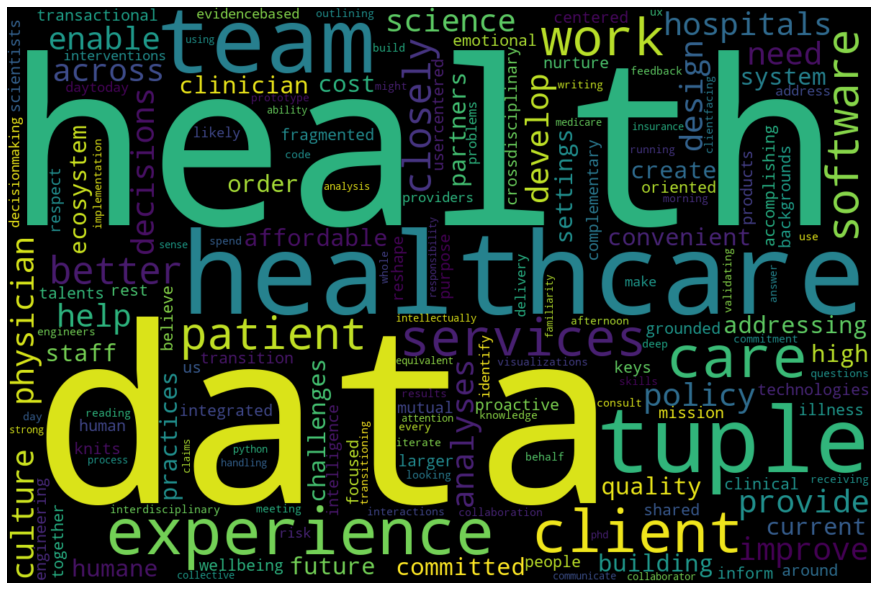

In [398]:
#### Word cloud of job description ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in final_processed_text: 
     
   # typecaste each val to string 
   val = str(val) 
 
   # split the value 
   tokens = val.split() 
     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
 
 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='black', 
               stopwords = stopwords, 
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
#plt.savefig('job title word cloud.png')
plt.show() 


# TF-IDF Vectorization

In [464]:
VECTOR_LENGTH = 500
MAX_NGRAM_LENGTH = 2

Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating dataframe from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index=labels)
matrix


,ability,abt,abt associates,across,analyses,analysis,analyst,analytic,analytic skills,analytics,...,wrangling manipulation,wrangling modeling,writing,writing code,years,years communicated,years managed,years working,york,york city
Tuple_Job_Description,0.041754,0.000000,0.000000,0.109803,0.109803,0.041754,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.054902,0.054902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Resume,0.023347,0.116733,0.093386,0.000000,0.000000,0.140079,0.061396,0.023347,0.023347,0.092094,...,0.030698,0.000000,0.000000,0.000000,0.046693,0.030698,0.000000,0.030698,0.093386,0.093386
Cover_Letter,0.000000,0.052622,0.052622,0.000000,0.000000,0.000000,0.000000,0.052622,0.052622,0.000000,...,0.000000,0.069191,0.000000,0.000000,0.052622,0.000000,0.069191,0.000000,0.052622,0.052622


In [465]:
# Explore TFIDF Values - set average value and identify outliers
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF = pd.DataFrame(average_TFIDF,index = [0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

# sort by highest average TF-IDF score
average_TFIDF_DF.sort_values(by=['TFIDF'], ascending=False)

,TFIDF
data,0.308736
health,0.193652
experience,0.113039
healthcare,0.105208
tuple,0.104671
science,0.103253
collection,0.099315
data collection,0.099315
project,0.097338
position,0.092255


In [466]:
#Dataframe of TF-IDF of job description
THC_df = pd.DataFrame(matrix.iloc[0])
THC_df.head()

,Tuple_Job_Description
ability,0.041754
abt,0.000000
abt associates,0.000000
across,0.109803
analyses,0.109803


In [403]:
# BMPA = matrix.iloc[42]
# type(BMPA)
# BMPA.sort_values(ascending=False)

In [405]:
# Select specific words accross documents
# people = matrix['people']
# people.sort_values(ascending=False)    

In [467]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_df = pd.DataFrame(cosine_similarity(matrix), columns = labels, index = labels)
cos_sim_df 
#.19 cosine similarity with resume, not too bad
#.24 cosine similarity with cover letter

,Tuple_Job_Description,Resume,Cover_Letter
Tuple_Job_Description,1.000000,0.196967,0.245256
Resume,0.196967,1.000000,0.492109
Cover_Letter,0.245256,0.492109,1.000000


In [468]:
#PCA of word vectors
from sklearn.decomposition import PCA
from matplotlib import pyplot
# PCA Scatterplot
def princomp_scatter(text):
    sentences = text
    model = Word2Vec(sentences, min_count=1)
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.figure(figsize = (15, 12))
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
      pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


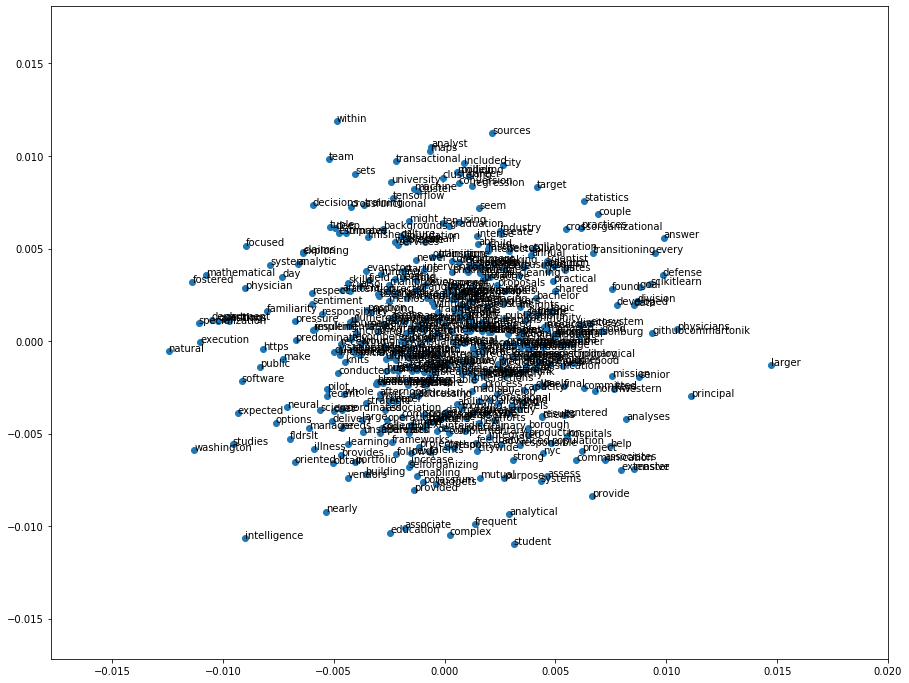

In [469]:
princomp_scatter(combined_text) # PCA doesnt do much for two documents like this - need a larger corpus or use with Word2Vec